# BASELINE FOR MEME CLASSIFIER

Sources:


*   https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5
*   https://stackabuse.com/text-classification-with-python-and-scikit-learn/
*   https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
*   https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2 (task2)



### DRIVE LINKING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### CONSTANTS

In [ ]:
LABELS = {
    'Black-and-white Fallacy/Dictatorship': 0,
    'Loaded Language': 1, 
    'Name calling/Labeling': 2, 
    'Slogans': 3, 
    'Smears': 4, 
    'Causal Oversimplification': 5, 
    'Appeal to fear/prejudice': 6, 
    'Exaggeration/Minimisation': 7, 
    'Reductio ad hitlerum': 8, 
    'Repetition': 9, 
    'Glittering generalities (Virtue)': 10, 
    "Misrepresentation of Someone's Position (Straw Man)": 11, 
    'Doubt': 12, 
    'Obfuscation, Intentional vagueness, Confusion': 13, 
    'Whataboutism': 14, 
    'Flag-waving': 15, 
    'Thought-terminating cliché': 16, 
    'Presenting Irrelevant Data (Red Herring)': 17, 
    'Appeal to authority': 18, 
    'Bandwagon': 19,
}
N_LABELS = len(LABELS)

### IMPORTS

In [ ]:
import numpy as np
import pandas as pd

import json

import re

from tabulate import tabulate
import seaborn as sn

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## TASK 1

### DATASET

In [ ]:
def load_datasets(task_number):

    folder = "drive/MyDrive/DeepLearning/Dataset/"

    if   task_number == 1:
        train_path = folder + "task1/training_set_task1.txt"
        test_path = folder + "task1/test_set_task1.txt"
        dev_path = folder + "task1/dev_set_task1.txt"
    elif task_number == 2:
        train_path = folder + "task2/training_set_task2.txt"
        test_path = folder + "task2/test_set_task2.txt"
        dev_path = folder + "task2/dev_set_task2.txt"
    elif task_number == 3:
        train_path = folder + "task3/training/training_set_task3.txt"
        test_path = folder + "task3/test/test_set_task3.txt"
        dev_path = folder + "task3/dev/dev_set_task3.txt"
    else:
        raise AssertionError('Bad task_number. Possible inputs: 1, 2, 3.')

    def load_json2pandas(path): 
        
        with open(path) as f:
            data = json.load(f)
        return pd.DataFrame(data)

    train = load_json2pandas(train_path)
    test = load_json2pandas(test_path)
    dev = load_json2pandas(dev_path)

    return train, test, dev

In [ ]:
def one_hot_encoder(labels):

    def encode(labels):

        ohe_label = [0] * N_LABELS
        for l in labels:
            ohe_label[LABELS[l]] = 1

        return ohe_label

    return np.array([encode(l) for l in labels])

In [ ]:
def process_sentences(sentences):

    stemmer = WordNetLemmatizer()

    def process_sentence(sentence):

        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(sentence))
        
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
        
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)
        
        # Converting to Lowercase
        document = document.lower()
        
        # Lemmatization
        document = document.split()

        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)

        return document

    return [process_sentence(sen) for sen in sentences]

In [ ]:
def process_dataset(train, test, dev):

    documents = np.concatenate([
        process_sentences(train.text),
        process_sentences(test.text),
        process_sentences(dev.text)])

    tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        max_df=0.7,
                        stop_words='english')
    
    X = tfidf.fit_transform(documents).toarray()

    X_train = X[:len(train)]
    X_test = X[len(train):len(train)+len(test)]
    X_dev = X[len(train)+len(test):]

    y_train = one_hot_encoder(train.labels)
    y_test = one_hot_encoder(test.labels)
    y_dev = one_hot_encoder(dev.labels)

    return X_train, y_train, X_test, y_test, X_dev, y_dev

#### VISUALIZING DATA

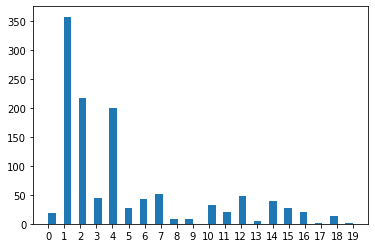

In [ ]:
def plot_labels_histo(ds):

    labels = [LABELS[l] for l_list in ds.labels for l in l_list]

    plt.hist(labels, bins=40)
    plt.xticks(range(0, max(labels) + 1))
    plt.show()

train, _, _ = load_datasets(1)
plot_labels_histo(train)

### TRAINING 

In [ ]:
def train_classifier(clf, X_train, y_train, X_val, y_val):
    """Trains a classifier over train data and prints 
    the evaluation on val data."""

    clf.fit(X_train, y_train)

    prediction = clf.predict(X_val)

    print('Eval f_micro is {:10.4f}'.format(
        f1_score(y_val, prediction, average='micro')))
    print('Eval f_macro is {:10.4f}'.format(
        f1_score(y_val, prediction, average='macro')))

In [ ]:
train, test, dev = load_datasets(1)

X_train, y_train, X_test, y_test, X_dev, y_dev = process_dataset(
    train, test, dev)

print("Train features shape:", X_train.shape)
print("Train labels shape:", y_train.shape)

print("\nTest features shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

print("\nDev features shape:", X_dev.shape)
print("Dev labels shape:", y_dev.shape)

Train features shape: (688, 364)
Train labels shape: (688, 20)

Test features shape: (200, 364)
Test labels shape: (200, 20)

Dev features shape: (63, 364)
Dev labels shape: (63, 20)


In [ ]:
classifiers = [
    DummyClassifier(strategy="uniform"),
    DummyClassifier(strategy="stratified"),
    OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)),
    OneVsRestClassifier(LinearSVC()),
]

for clf in classifiers:
    print(clf)
    
    train_classifier(clf, X_train, y_train, X_test, y_test)
    print()

DummyClassifier(strategy='uniform')
Eval f_micro is     0.1497
Eval f_macro is     0.1246

DummyClassifier(strategy='stratified')
Eval f_micro is     0.2595
Eval f_macro is     0.0648

OneVsRestClassifier(estimator=MultinomialNB())
Eval f_micro is     0.2637
Eval f_macro is     0.0381

OneVsRestClassifier(estimator=LinearSVC())
Eval f_micro is     0.3154
Eval f_macro is     0.0942



## TASK 3

In [ ]:
train, test, dev = load_datasets(1)

X_train, y_train, X_test, y_test, X_dev, y_dev = process_dataset(
    train, test, dev)

print("Train features shape:", X_train.shape)
print("Train labels shape:", y_train.shape)

print("\nTest features shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

print("\nDev features shape:", X_dev.shape)
print("Dev labels shape:", y_dev.shape)

Train features shape: (688, 364)
Train labels shape: (688, 20)

Test features shape: (200, 364)
Test labels shape: (200, 20)

Dev features shape: (63, 364)
Dev labels shape: (63, 20)


In [ ]:
classifiers = [
    DummyClassifier(strategy="uniform"),
    DummyClassifier(strategy="stratified"),
    OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)),
    OneVsRestClassifier(LinearSVC()),
]

for clf in classifiers:
    print(clf)
    
    train_classifier(clf, X_train, y_train, X_test, y_test)
    print()

DummyClassifier(strategy='uniform')
Eval f_micro is     0.1359
Eval f_macro is     0.1148

DummyClassifier(strategy='stratified')
Eval f_micro is     0.2403
Eval f_macro is     0.0680

OneVsRestClassifier(estimator=MultinomialNB())
Eval f_micro is     0.2637
Eval f_macro is     0.0381

OneVsRestClassifier(estimator=LinearSVC())
Eval f_micro is     0.3154
Eval f_macro is     0.0942



## TASK 2

### DATASET

In [ ]:
class Span():


    def __init__(self, start=-1, end=-1):

        if start > end: 
            start = -1 
            end = -1
        self.start = start
        self.end = end

    def is_valid(self) -> bool: 

        return self.start >= 0 and self.end >= 0 and self.start <= self.end

    def intersect(self, other):

        if not self.is_valid() or not other.is_valid(): 
            return Span()
        return Span(max(self.start, other.start), min(self.end, other.end))

    def length(self) -> int: 

        if not self.is_valid(): 
            return 0
        return self.end - self.start

    def __eq__(self, __o: object) -> bool:

        return self.start == __o.start and self.end == __o.end

    def __lt__(self, __o: object) -> bool:

        if self.start == __o.start: 
            return ((self.end) < (__o.end))
        return ((self.start) < (__o.start))

    def __str__(self) -> str:

        return "({}, {})".format(self.start, self.end)

    def __repr__(self) -> str:

        return "({}, {})".format(self.start, self.end)

In [ ]:
class Dataset():


    def __init__(self, X, y, pos_map, sen_map, y_spans):

        self.X = X
        self.y = y

        self.pos_map = pos_map
        self.sen_map = sen_map

        self.y_spans = y_spans


def get_sentence_data(sentence, label_dict, i):

    def get_word_data(m, i):

        tag = [0] * N_LABELS
        for d in label_dict:
            if d['start'] <= m.start() and d['end'] >= m.end():
                tag[LABELS[d['technique']]] = 1

        return {'sentence': i, 
                'word': m.group().lower(), 
                'tag': tag, 
                'span': Span(m.start(), m.end())}

    iterator = re.finditer(r'\w+|[^\w\s]+', sentence)
    return [get_word_data(match, i) for match in iterator]

def process_dataset(train, test, dev):

    def process(data):

        def label_dicts_to_spans(label_dicts):

            spans = [[] for _ in range(N_LABELS)]
            for d in label_dicts: 
                t_num = LABELS[d['technique']]
                spans[t_num].append(Span(d['start'], d['end']))

            return spans

        sentences = data.text
        label_dicts = data.labels

        res = []
        for i, [s, l] in enumerate(zip(sentences, label_dicts)):
            res.extend(get_sentence_data(s, l, i))

        spans = [label_dicts_to_spans(ds) for ds in label_dicts]

        return pd.DataFrame(res), spans

    train, train_spans = process(train)
    test, test_spans = process(test)
    dev, dev_spans = process(dev)

    df = pd.concat([train, test, dev])

    X = df.drop(['tag', 'span'], axis=1)
    v = DictVectorizer(sparse=False)
    X = v.fit_transform(X.to_dict('records'))
    y = np.stack(df.tag.values)

    pos_map = np.stack(df.span.values)
    sen_map = np.stack(df.sentence.values)

    l_train = len(train)
    l_test = len(test)

    def make_dataset(s, e, spans): 
        return Dataset(X[s:e], y[s:e], pos_map[s:e], sen_map[s:e], spans)

    train = make_dataset(0, l_train, train_spans)
    test = make_dataset(l_train, l_train+l_test, test_spans)
    dev = make_dataset(l_train+l_test, len(X), dev_spans)

    return train, test, dev

### TRAINING

In [ ]:
train, test, dev = load_datasets(2)

train, test, dev = process_dataset(train, test, dev)

print("Train features shape:", train.X.shape)
print("Train labels shape:", train.y.shape)

print("\nTest features shape:", test.X.shape)
print("Test labels shape:", test.y.shape)

print("\nDev features shape:", dev.X.shape)
print("Dev labels shape:", dev.y.shape)

Train features shape: (14760, 3927)
Train labels shape: (14760, 20)

Test features shape: (4083, 3927)
Test labels shape: (4083, 20)

Dev features shape: (1406, 3927)
Dev labels shape: (1406, 20)


In [ ]:
classifiers = [
    DummyClassifier(strategy="uniform"),
    DummyClassifier(strategy="stratified"),
    OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)),
    OneVsRestClassifier(LinearSVC()),
]

for clf in classifiers:
    print(clf)

    train_classifier(clf, train.X, train.y, test.X, test.y)
    print()

DummyClassifier(strategy='uniform')
Eval f_micro is     0.0809
Eval f_macro is     0.0731

DummyClassifier(strategy='stratified')
Eval f_micro is     0.1173
Eval f_macro is     0.0406

OneVsRestClassifier(estimator=MultinomialNB())
Eval f_micro is     0.0612
Eval f_macro is     0.0223

OneVsRestClassifier(estimator=LinearSVC())


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

Eval f_micro is     0.0742
Eval f_macro is     0.0331



### TESTING

In [ ]:
def ohe_to_spans(ohe, pos_map, sen_map):

    def in_sentence_groups(x_list, sen_map):
        '''Returns "x_list" regrouped as in "sen_map".'''

        d = {}

        def add(x, group):
            
            if group in d:
                d[group].append(x)
            else:
                d[group] = [x]

        for x, s in zip(x_list, sen_map):
            add(x, s)
        
        return [np.stack(x) for x in d.values()]

    def ohe_sentence_to_spans(ohe_sentence, pos_map_sentence):

        results = []
        for class_res in ohe_sentence.T:
            result = []
            cur_span = None
            for tok_res, tok_span in zip(class_res, pos_map_sentence):
                if cur_span is None:
                    if tok_res == 1:
                        cur_span = tok_span
                else:
                    if tok_res == 1:
                        cur_span.end = tok_span.end
                    if tok_res == 0:
                        result.append(cur_span)
                        cur_span = None

            if cur_span is not None: result.append(cur_span)
            results.append(result)
            
        return results

    return [
        ohe_sentence_to_spans(ohe, pos) for ohe, pos in zip(
            in_sentence_groups(ohe, sen_map),
            in_sentence_groups(pos_map, sen_map))]

In [ ]:
def C(s, t, h): return s.intersect(t).length() / h

def precision_metric(S, T):

    Sn = 0
    sum = 0
    for c_S, c_T in zip(S, T):
        for s in c_S:
            for t in c_T: 
                sum += C(s, t, s.length())

        Sn += len(c_S)

    if Sn == 0 and sum == 0: 
        return 1
    if Sn == 0: 
        return 0

    return sum / Sn

def recall_metric(S, T): return precision_metric(T, S)

def f1_metric(pred_spans, label_spans):

    p_sum = 0
    r_sum = 0
    for S, T in zip(pred_spans, label_spans):
        p_sum += precision_metric(S, T)
        r_sum += recall_metric(S, T)

    p = p_sum / len(pred_spans)
    r = r_sum / len(pred_spans)

    return 2 * (p*r) / (p+r), p, r

def test_classifier(clf, X_test, y_test_spans, pos_map, sen_map):
    """Tests a classifier using test data and labels in the
    form of spans."""

    y_pred_ohe = clf.predict(X_test)

    y_pred_spans = ohe_to_spans(y_pred_ohe, pos_map, sen_map)

    f1, p, r = f1_metric(y_pred_spans, y_test_spans)

    print(clf)
    print('Test f1 is {:10.4f}'.format(f1))
    print('Test precision is {:10.4f}'.format(p))
    print('Test recall is {:10.4f}'.format(r))
    print()

In [ ]:
for clf in classifiers:
    test_classifier(
        clf, test.X, test.y_spans, test.pos_map, test.sen_map)

DummyClassifier(strategy='uniform')
Test f1 is     0.0826
Test precision is     0.0426
Test recall is     1.3069

DummyClassifier(strategy='stratified')
Test f1 is     0.1649
Test precision is     0.0996
Test recall is     0.4791

OneVsRestClassifier(estimator=MultinomialNB())
Test f1 is     0.4213
Test precision is     0.5729
Test recall is     0.3332

OneVsRestClassifier(estimator=LinearSVC())
Test f1 is     0.2577
Test precision is     0.1952
Test recall is     0.3791

